<a href="https://colab.research.google.com/github/pejmanrasti/From_Shallow_to_Deep/blob/main/2_1_TinyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

## Loading Training and Validation Data

we use the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 2935.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split

! pip install TensorBoardColab
from tensorflow.keras.models import Sequential,Model # Model type to be used
from tensorflow.keras.layers import Dense, Activation, Dropout# Make Fully connected (FC) layers
from tensorflow.keras.utils import to_categorical # NumPy related tools
from tensorflow.keras.callbacks import TensorBoard  #Visulization of Accuracy and loss
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

  Created wheel for TensorBoardColab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3859 sha256=663d2cb7a32bdfcb13886acc5d6eda071a9736d2d6b6be45364dcf09b1861713
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built TensorBoardColab


In [4]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount( root )

Mounted at /content/gdrive/


In [5]:
!unzip gdrive/My\ Drive/data_Iran/101_ObjectCategories.zip

Streaming output truncated to the last 5000 lines.
  inflating: 101_ObjectCategories/Motorbikes/image_0736.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0736.jpg  
  inflating: 101_ObjectCategories/Motorbikes/image_0078.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0078.jpg  
  inflating: 101_ObjectCategories/Motorbikes/image_0285.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0285.jpg  
  inflating: 101_ObjectCategories/Motorbikes/image_0291.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0291.jpg  
  inflating: 101_ObjectCategories/Motorbikes/image_0246.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0246.jpg  
  inflating: 101_ObjectCategories/Motorbikes/image_0520.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0520.jpg  
  inflating: 101_ObjectCategories/Motorbikes/image_0534.jpg  
  inflating: __MACOSX/101_ObjectCategories/Motorbikes/._image_0534.jpg  
  in

In [6]:
DATADIR = "101_ObjectCategories"
CATEGORIES = os.listdir(DATADIR)
print(CATEGORIES)

['Faces_easy', 'accordion', 'tick', 'wild_cat', 'joshua_tree', 'scorpion', 'mandolin', 'stop_sign', 'sunflower', 'starfish', 'hawksbill', 'strawberry', 'saxophone', 'crocodile', 'kangaroo', 'revolver', 'laptop', 'watch', 'crocodile_head', 'emu', 'Motorbikes', 'llama', 'camera', 'ibis', 'ferry', 'sea_horse', 'stapler', 'water_lilly', 'windsor_chair', 'cup', 'octopus', 'car_side', 'hedgehog', 'anchor', 'ceiling_fan', 'ketch', 'butterfly', 'rooster', 'dalmatian', 'mayfly', 'crab', 'electric_guitar', 'pyramid', 'buddha', 'inline_skate', 'chair', 'umbrella', 'barrel', 'cougar_face', 'pizza', 'airplanes', 'helicopter', 'gerenuk', 'crayfish', 'grand_piano', 'gramophone', 'binocular', 'pagoda', 'lotus', 'dragonfly', 'Leopards', 'cannon', 'euphonium', 'BACKGROUND_Google', 'ewer', 'chandelier', 'cellphone', 'bass', 'brontosaurus', 'nautilus', 'wrench', 'garfield', 'flamingo', 'dollar_bill', 'stegosaurus', 'snoopy', 'elephant', 'scissors', 'minaret', 'okapi', 'menorah', 'yin_yang', 'platypus', 'w

In [7]:
CATEGORIES = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
print(CATEGORIES)

['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']


In [8]:
training_data = []
IMG_SIZE_H=224 # you need to set up a numerical value here. Useful to resize to normalize data size
IMG_SIZE_W=224 # you need to set up a numerical value here. Useful to resize to normalize data size
def create_training_data():
    for category in CATEGORIES:  # do plants and weeds

        path = os.path.join(DATADIR,category)  # create path to the labels
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=plants 1=weeds

        for img in os.listdir(path):  # iterate over each image per plants and weeds
          if img.endswith('.jpg'):
            img_array = cv2.imread(os.path.join(path,img))  # convert to array 
            new_array = cv2.resize(img_array, (IMG_SIZE_H, IMG_SIZE_W))  # resize to normalize data size
            training_data.append([new_array, class_num])  # add this to our training_data


In [9]:
create_training_data()  # Calling the function for reading images and labels
print(len(training_data)) # Printing the size of the database

2935


Preparation of data for importing to Keras

In [10]:
random.shuffle(training_data)
X = []  # An Array for images
y = []  # An Array for labels

for features,label in training_data:   # Seperation of iamegs and labels
    X.append(features)
    y.append(label)
print(np.array(X).shape) # Print the size of the database

(2935, 224, 224, 3)


In [11]:
X = np.array(X).reshape(-1, IMG_SIZE_H, IMG_SIZE_W, 3)  # Reshape data in a form that is suitable for keras
print(X.shape) # Print the size of the database

(2935, 224, 224, 3)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

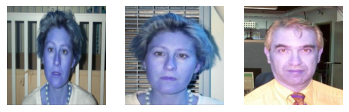

In [14]:
# Display 3 images 
plt.subplot(131)
plt.imshow(X[0,:,:,:])
plt.axis("off")
plt.subplot(132)
plt.imshow(X[10,:,:,:])
plt.axis("off")
plt.subplot(133)
plt.imshow(X[1000,:,:,:]) 
plt.axis("off")
# show the plot
plt.show()

# **Importing necessary Libraries**

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers. After the last pooling layer, we will attach a fully-connected layer with 256 neurons then finally a softmax classification layer for our classes.



In [15]:
# normalize data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [28]:
# build the network
model = tf.keras.applications.MobileNet(weights=None, include_top=True)

model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [29]:
# make a reference to VGG's input layer
inp = model.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(5, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(model.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [23]:
! pip install livelossplot
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = 'checkpointCNNtiny.h5'
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto') #Callback to save the Keras model or model weights at some frequency.

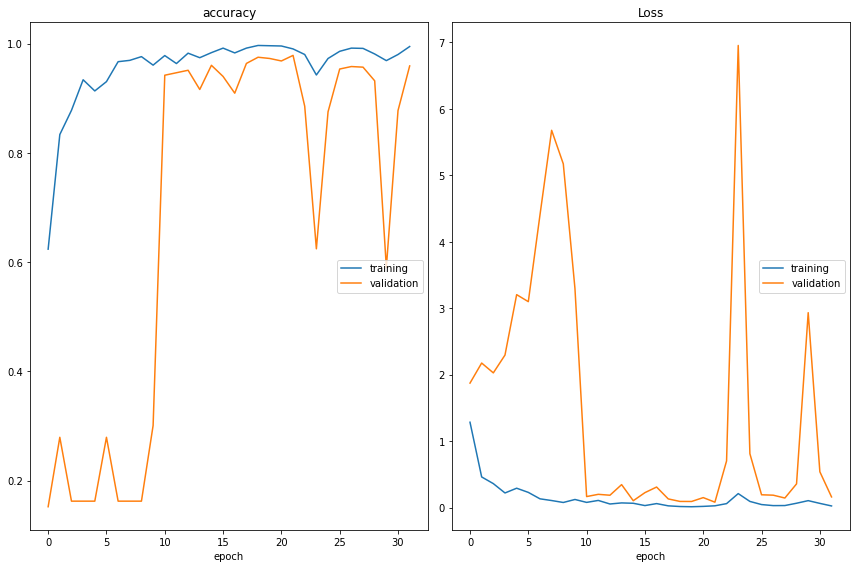

accuracy
	training         	 (min:    0.624, max:    0.997, cur:    0.995)
	validation       	 (min:    0.152, max:    0.978, cur:    0.959)
Loss
	training         	 (min:    0.013, max:    1.284, cur:    0.025)
	validation       	 (min:    0.082, max:    6.953, cur:    0.161)

Epoch 32: val_loss did not improve from 0.08162
65/65 [==============================] - 14s 215ms/step - loss: 0.0249 - accuracy: 0.9946 - val_loss: 0.1607 - val_accuracy: 0.9591
Epoch 32: early stopping


In [30]:
model_new.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model_new.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=50, batch_size=32,
          verbose=1,
          callbacks=[plotlosses,early_stop, Model_check])

**Evaluation and Prediction**

We can use our model to make a prediction on new images.

In [31]:
model_New_load = tf.keras.models.load_model('checkpointCNNtiny.h5')
loss, accuracy = model_New_load.evaluate(X_test, y_test, verbose=0) #Evaluation of the model on the test dataset
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.08162043243646622
Test accuracy: 0.9784336090087891
